Code to obtain the minimum areametric values obtained from the coefficient interval.

In [47]:
pwd

'/Users/jaleenasunny/code_notebook/AM_Calibration/codes/Calibration_interval'

In [48]:

import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import integrate
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib as mpl
import scipy.stats
import statsmodels.api as sm
import pylab
import pandas as pd
import itertools
log10 = np.log10
#from AM_easy import areaMe
#from matplotlib import rc, rcParams
import areametric_easy as am
from matplotlib.ticker import ScalarFormatter

In [49]:
df1 = pd.read_csv("/Users/jaleenasunny/code_notebook/AM_Calibration/data/Regionalized.csv",sep=',')

df1 = df1.dropna()

ed = df1["epi_dist"] <= 1000
df2 = df1[ed]

m = df2["Mw"] <= 7.6
df3 = df2[m]

m2 = df3["Mw"] >= 4
df4 = df3[m2]

gr = df4["CSZ_ID"] == "SZ49"
df = df4[gr]
df

,event_id,event_time,ev_nation_,ev_latitud,ev_longitu,ev_depth_k,fm_type_co,Mw,vs30_m_sec,epi_dist,U_pga,V_pga,W_pga,CSZ_ID
241,AL-2016-0003,10/11/2016 12:12,GR,41.0713,22.6802,10.0000,U,4.4,742.0,167.2,-0.048682,0.057708,-0.029478,SZ49
249,AL-2016-0012,21/05/2016 17:16,MK,41.2111,21.0831,13.1700,SS,4.2,202.0,136.8,0.521813,-0.485882,0.272476,SZ49
250,AL-2016-0012,21/05/2016 17:16,MK,41.2111,21.0831,13.1700,SS,4.2,742.0,69.9,0.306977,0.284795,0.215518,SZ49
251,AL-2016-0012,21/05/2016 17:16,MK,41.2111,21.0831,13.1700,SS,4.2,745.0,111.1,0.105144,0.105043,0.060152,SZ49
252,AL-2016-0012,21/05/2016 17:16,MK,41.2111,21.0831,13.1700,SS,4.2,1490.0,123.3,-0.033425,-0.043859,-0.031760,SZ49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,GR-1995-0022,15/05/1995 04:13,GR,40.0767,21.6538,25.8000,NF,5.2,615.0,9.2,-131.687838,158.816257,-63.883847,SZ49
531,GR-1995-0022,15/05/1995 04:13,GR,40.0767,21.6538,25.8000,NF,5.2,421.0,27.7,-39.065102,26.177256,26.736379,SZ49
540,GR-1995-0033,19/05/1995 06:48,GR,40.0857,21.6033,10.0000,NF,5.1,421.0,28.8,10.688100,14.098776,4.719485,SZ49
561,MK-1994-0004,01/09/1994 16:12,MK,41.1806,21.2049,12.4000,O,6.1,347.0,82.5,24.609378,-23.016695,7.679682,SZ49


In [50]:
#getting the required parameters

epidis = df["epi_dist"]
epidis = epidis.to_numpy()
#epidis = epidis.tolist()
M = df["Mw"]
M = M.to_numpy()
#M = M.tolist()
foc = df["ev_depth_k"]
foc = foc.tolist()
vs30 = df["vs30_m_sec"]
vs30 = vs30.to_numpy()
sof = df["fm_type_co"]
sof = sof.to_numpy()
obspga_U = df["U_pga"]
obspga_W = df["W_pga"]
obspga_v = df["V_pga"]
event_coun = df["CSZ_ID"]
event_coun = event_coun.tolist()

In [51]:
#defining the observed ground motion intensity as the square root of the product of horizontal components (here pga)
gm = [a * b for a,b in zip(obspga_U,obspga_W)]
obspgar = [math.sqrt(abs(i)) for i in gm]

In [52]:
#Observed data in log10 scale
obspgalog=[math.log10(k) for k in obspgar]
obspgalog1=[math.log10(k) for k in obspgar]

In [53]:
#converting epicentral distance to hypocentral distance for applying GMPE

R = []
for i in range (len(M)):
    R.append(math.sqrt(epidis[i]**2 + foc[i]**2))  

R = np.asarray(R)

In [54]:
#getting different ranges of magnitude and distance data
opga_5_40 = []
opga_5_300 = []
opga_7_300 = []
opga_7_40 = []
M_5_40 = []
R_5_40 = []
sof_5_40 = []
vs30_5_40 = []
M_5_300 = []
R_5_300 = []
sof_5_300 = []
vs30_5_300 = []


for i in range(len(M)):
    if M[i] < 5 and epidis[i] < 40:
        opga_5_40.append(obspgalog[i])
        M_5_40.append(M[i])
        R_5_40.append(R[i])
        sof_5_40.append(sof[i])
        vs30_5_40.append(vs30[i])
        
    elif M[i] < 5 and epidis[i] > 40:
        opga_5_300.append(obspgalog[i])
        M_5_300.append(M[i])
        R_5_300.append(R[i])
        sof_5_300.append(sof[i])
        vs30_5_300.append(vs30[i])
        
    elif  M[i] > 5 and epidis[i] > 40:
        opga_7_300.append(obspgalog[i])
        
    elif  M[i] > 5 and epidis[i] < 40:
        opga_7_40.append(obspgalog[i])
        
M_5_40 = np.asarray(M_5_40)
R_5_40 = np.asarray(R_5_40)
vs30_5_40 = np.asarray(vs30_5_40)
sof_5_40 = np.asarray(sof_5_40)
M_5_300 = np.asarray(M_5_300)
R_5_300 = np.asarray(R_5_300)
vs30_5_300 = np.asarray(vs30_5_300)
sof_5_300 = np.asarray(sof_5_300)

In [55]:
#defining the ecdf as a step function and getting the stairs for plots

def ecdf(data):
        x1 = np.sort(data)
        x = x1.tolist()
        n = len(x)
        p = 1/n
        pvalues = list(np.linspace(p,1,n))
        return x, pvalues
def stairs(data):
        def stepdata(x,y): # x,y must be python lists
            
            xx,yy = x*2, y*2
            xx.sort()
            yy.sort()
            return xx, [0.]+yy[:-1]
        x, p = ecdf(data)
        x, y = stepdata(x,p)
        return x, y

In [56]:
#to get confidence band around empirical data using Dvoretzky–Kiefer–Wolfowitz inequality.

def conf(data,target):
    X,Y = stairs(data)
    b_lo = []
    b_hi = []
    n = len(Y)
    alpha = 1 - target
    e = np.sqrt(((np.log(2/alpha))/(2*n)))

    for i in range(len(Y)):
        if Y[i] - e < 0:
            b_lo.append(max(0,Y[i] - e))
        else:
            b_lo.append(Y[i] - e)
        if Y[i] + e > 1:
            b_hi.append(min(1,Y[i] + e))
        else:
            b_hi.append(Y[i] + e)
        
    return b_lo,b_hi

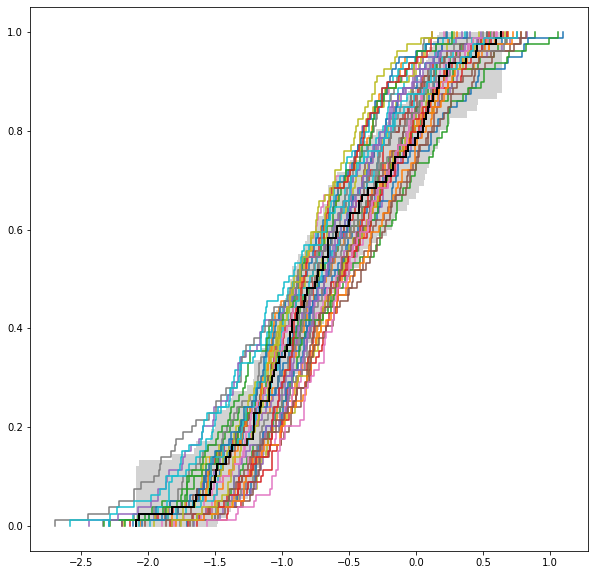

In [75]:
import dists
import AM_easy
import numpy


log10 = numpy.log10
Mh = 6.75
Mref=5.5
Rref = 1
Vref = 800
sigma_real = 0.325

#function to get the Bindi GMM

def GMM(e1,c1,c2,c3,h,b1,b2,b3,gama,sofN,sofR,sofS):

    def FD(R,M):
        fd1 = c1 + (c2* (M-Mref))
        R_sq = R**2
        Hsq = h**2
        R_hypo = (R_sq + Hsq)**0.5
        fd2 = log10(R_hypo)
        fd3 = c3  * (R_hypo - Rref)
        fd = (fd1*fd2)-fd3
        return fd
    def FM(M):
        fm = np.empty((M.shape))
        fm[M<Mh] = (b1 * (M[M<Mh] - Mh)) + (b2 * ((M[M<Mh] - Mh)**2))
        fm[M>=Mh]= b3 * (M[M>=Mh] - Mh)
        return fm
    def FS(vs30):
        fs = gama * math.log10(vs30/Vref)
        return fs
    f_vector = np.vectorize(FS)
    def FSOF(sof):
        fsof = np.empty((sof.shape))
        fsof[sof == "U"] = 0
        fsof[sof == "NF"] = sofN
        fsof[sof == "TF"] = sofS
        fsof[sof == "SS"] = sofS
        fsof[sof == 'O'] = 0 
        return fsof

        return fm
    log10_Y = e1+FD(R_5_300,M_5_300)+FM(M_5_300)+FSOF(sof_5_300) + f_vector(vs30_5_300)
    return log10_Y

#function to return the sigma value (only if required)

def sigma(observed, predicted):
    res = [a-b for a,b in zip(predicted,observed)]
    sig = np.std(res)
    return sig

#to obtain the possible coefficients corresponding to min AMs assuming each coefficient follows a normal distribution.

if __name__ == '__main__': 
    h_ = 4.82743

    e1_ = 4.27391
    c1_ = -1.578281
    c2_ = 0.108218
    c3_ = 9.64e-5
    b1_ = 0.217109
    b2_ = -0.06826
    b3_ = 0.352976
    gama_ = -0.293242
    sofN_ = -0.04721
    sofR_ = 0.110979
    sofS_ = -0.06376
    logY_ = GMM(e1_,c1_,c2_,c3_,h_,b1_,b2_,b3_,gama_,sofN_,sofR_,sofS_)
    AM = AM_easy.areaMe(list(logY_),opga_5_40)
    
    RESiduals = [a-b for a,b in zip(list(logY_),opga_5_300)]
    SIG = np.std(RESiduals)
    
    many = 1000
    e1_normal_samples = dists.normal(e1_,1).sample(N=many)
    c1_normal_samples = dists.normal(c1_,1).sample(N=many)
    c2_normal_samples = dists.normal(c2_,.5).sample(N=many)
    c3_normal_samples = dists.normal(c3_,.0001).sample(N=many)
    b1_normal_samples = dists.normal(b1_,.1).sample(N=many)
    b2_normal_samples = dists.normal(b2_,.01).sample(N=many)
    b3_normal_samples = dists.normal(b3_,0.1).sample(N=many)
    h_normal_samples = dists.normal(h_,1).sample(N=many)
    gama_normal_samples = dists.normal(gama_,0.1).sample(N=many)
    sofN_normal_samples = dists.normal(sofN_,0.01).sample(N=many)
    sofR_normal_samples = dists.normal(sofR_,0.1).sample(N=many)
    sofS_normal_samples = dists.normal(sofS_,0.01).sample(N=many)
    
    
#obtaining the first 40 models which gives minimum AM values

    AM_candidates = []
    AM_minimum = float('inf')
    AM_sigma_minimum = float('inf')
    i_min = 0
    all_i = []
    AM_i = []
    sigma_i = []
    Y_sigma = []
    numbr = 40
    
    
    for i in range(many):
        logY_i = GMM(e1_normal_samples[i],c1_normal_samples[i],c2_normal_samples[i],c3_normal_samples[i],h_normal_samples[i],b1_normal_samples[i],b2_normal_samples[i],b3_normal_samples[i],gama_normal_samples[i],sofN_normal_samples[i],sofR_normal_samples[i],sofS_normal_samples[i])
        sigma_i = ((sigma(opga_5_300, logY_i)))
        np.random.seed(5)
        Y1_sigma = logY_i + np.random.normal(0,sigma_real)
        np.random.seed(5)
        Y_sigma.append(logY_i + np.random.normal(0,sigma_real))
        AM_i.append(AM_easy.areaMe(list(Y1_sigma),opga_5_300))
    AM_sort = np.sort(AM_i)
    i = numpy.argsort(AM_i)   
    all_i.append(i[:numbr])
    i_val = all_i[0].tolist()
    
    
    for j in range(len(i_val)):
        i = i_val[j]
        m,n = stairs(Y_sigma[i])
        
        y_lo,y_hi = conf(opga_5_300,0.95)
        X,Y = stairs(opga_5_300)

#plotting the ecdf, the confidence bound of the ecdf and the 40 models

        plt.rcParams["figure.figsize"] = (10,10)
        plt.plot(X,Y,color='black')
        plt.plot(m,n)
        plt.fill_between(X, y_lo,y_hi,color='lightgray')

